In [24]:
import numpy as np
import matplotlib.pylab as pt
import torch as tr
import random

In [25]:
class Scorer:
    def __init__(self, contig):
        self.contig = contig
        self.conv2d = tr.nn.Conv2d(1, 4, contig, padding='same', bias=False)
        self.conv2d.requires_grad_(False)

        self.conv2d.weight[:] = 0
        self.conv2d.weight[0,0,0,:contig] = 1
        self.conv2d.weight[1,0,:contig,0] = 1
        self.conv2d.weight[2,0,:contig,:contig] += tr.eye(contig)
        self.conv2d.weight[3,0,:contig,:contig] += tr.rot90(tr.eye(contig))

    def check(self, board):
        board = board.reshape(-1, *board.shape[-2:]) # insert channel dim
        result = self.conv2d(board)
        #print(result)
        floored = tr.div(result, self.contig, rounding_mode='trunc')
        winner = floored.max() + floored.min() # -1, 0, +1 for lose, draw, win
        return winner


scorer = Scorer(4)

In [26]:
board = tr.zeros(6,7)
print(board)

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])


In [27]:
print(scorer.check(board))
board[4,:] = -1
board[4,4] = 0
board[4,5] = 0
print(board)
print(scorer.check(board))


tensor(0.)
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])
tensor(-1.)


In [28]:
class Connect4State(object):
    def __init__(self, board, scorer):
        self.board = board.clone()
        self.scorer = scorer
    def __str__(self):
        markers = np.full(self.board[:board.size(dim=1)-1,:].shape, ".")
        markers[self.board[:board.size(dim=1)-1,:] > 0] = "X"
        markers[self.board[:board.size(dim=1)-1,:] < 0] = "O"
        return "\n".join(["".join(row) for row in markers])

    def is_leaf(self):
        if self.score_for_max_player() != 0: return True
        return (self.board[:board.size(dim=1)-1,:] != 0).all()
        #return (self.board != 0).all() # tie game

    def score_for_max_player(self):
        return self.scorer.check(self.board).item()

    def is_max_players_turn(self):
        return self.board.sum() == 0 # +/-1 cancel when it is X's turn
    def is_min_players_turn(self):
        return not self.is_max_players_turn()
    
    def get_next_open_row(self, col):
        if tr.equal(tr.where(self.board[:,col] == 0)[0], tr.tensor([])) or tr.where(self.board[:,col] == 0)[0].size(dim=0) == 1:
            return None
        else:
            return tr.where(self.board[:,col] == 0)[0][-2]
        
    def valid_actions(self):
        return tr.tensor([ [self.get_next_open_row(col),col] for col in range(self.board.size(dim = 1)) if self.get_next_open_row(col) != None])
        #return tr.nonzero(self.board == 0)

    def perform(self, action):
        player = +1 if self.is_max_players_turn() else -1
        row, col = action
        new_state = Connect4State(self.board, self.scorer)
        new_state.board[row, col] = player
        return new_state

    
def initial_state(row_size, col_size, contig):
    board = tr.zeros((row_size, col_size))
    return Connect4State(board, Scorer(contig))




In [29]:
if __name__ == "__main__":
    
    from time import perf_counter
    start = perf_counter()
    state = initial_state(row_size=7, col_size = 7, contig=4)
    print(state)
    while True:
        if state.is_leaf(): break
        actions = state.valid_actions()
        print(actions.t())
        if len(actions) == 0: break
        state = state.perform(actions[0])
        print(state)
    print("max score, is over:")
    print(state.score_for_max_player())
    print(state.is_leaf())
    print(f"{perf_counter()-start}s to run")

.......
.......
.......
.......
.......
.......
tensor([[5, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 6]])
.......
.......
.......
.......
.......
X......
tensor([[4, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 6]])
.......
.......
.......
.......
O......
X......
tensor([[3, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 6]])
.......
.......
.......
X......
O......
X......
tensor([[2, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 6]])
.......
.......
O......
X......
O......
X......
tensor([[1, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 6]])
.......
X......
O......
X......
O......
X......
tensor([[0, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 6]])
O......
X......
O......
X......
O......
X......
tensor([[5, 5, 5, 5, 5, 5],
        [1, 2, 3, 4, 5, 6]])
O......
X......
O......
X......
O......
XX.....
tensor([[4, 5, 5, 5, 5, 5],
        [1, 2, 3, 4, 5, 6]])
O......
X......
O......
X......
OO.....
XX.....
tensor([[3, 5, 5, 5, 5, 5],
        [1, 2, 3, 4, 5, 6]])
O......
X......
O..

In [30]:
# Code to generate training data
# Each training example is an intermediate game state, paired with an approximate utility

# The depth-limited minimax algorithm
# Returns parent and child utilities
def minimax(state, max_depth):
    if max_depth == 0 or state.is_leaf():
        return state.score_for_max_player(), []
    else:
        child_utilities = [
            minimax(state.perform(action), max_depth - 1)[0]
            for action in state.valid_actions()]
        if state.is_max_players_turn():
            return max(child_utilities), child_utilities
        else:
            return min(child_utilities), child_utilities

def random_game(row_size, col_size, contig, max_depth):
    state = initial_state(row_size, col_size, contig)
    states = [state]
    while not state.is_leaf():
        utility, child_utilities = minimax(state, max_depth)
        ties = (np.array(child_utilities) == utility)
        tie_index = np.flatnonzero(ties)
        actions = state.valid_actions()
        action = actions[np.random.choice(tie_index)]
        state = state.perform(action)
        states.append(state)
    result = state.score_for_max_player()
    return states, result

# Used to generate a training data set
# Combines results from many random games
def generate(num_examples, row_size, col_size, contig, max_depth):
    all_states = []
    all_results = []
    num_games = 0
    while len(all_states) < num_examples:
        num_games += 1
        print(f"game {num_games}, {len(all_states)} of {num_examples} examples...")
        states, result = random_game(row_size, col_size, contig, max_depth)
        all_states += states
        all_results += [result] * len(states)

    return all_states, all_results

# Used to convert a game state to a tensor encoding suitable for NN input
# Uses one-hot encoding at each grid position
def encode(state):
    # encoding[0,:,:] == 1 where there are "_"s, 0 elsewhere
    # encoding[1,:,:] == 1 where there are "O"s, 0 elsewhere
    # encoding[2,:,:] == 1 where there are "X"s, 0 elsewhere
    symbols = tr.tensor([0, -1, +1]).reshape(-1,1,1)
    onehot = (symbols == state.board).float()
    return onehot


# Run some sanity checks to make sure generation and encoding are working
if __name__ == "__main__":

    row_size, col_size, contig = 7, 7, 4

    states, results = generate(num_examples=5, row_size=row_size, col_size = col_size, contig=contig, max_depth=4)
    for n, (state, result) in enumerate(zip(states, results)):
        print("example %d:" % n)
        print(state)
        print("result = %d" % result)
    print(state.score_for_max_player())

    print("Encoding of last example state:")
    encoding = encode(state)
    print(encoding)

    # quick test for encode
    print("")
    print("Encoding of initial state:")
    encoding = encode(initial_state(row_size, col_size, contig))
    print(encoding)
    assert(type(encoding) == tr.Tensor)
    expected = tr.zeros((3,row_size,col_size))
    expected[0,:,:] = 1
    assert((encoding == expected).all())
    
    print("If you see this line, initial state was encoded correctly")



game 1, 0 of 5 examples...
example 0:
.......
.......
.......
.......
.......
.......
result = 0
example 1:
.......
.......
.......
.......
.......
......X
result = 0
example 2:
.......
.......
.......
.......
.......
...O..X
result = 0
example 3:
.......
.......
.......
.......
......X
...O..X
result = 0
example 4:
.......
.......
.......
.......
......X
..OO..X
result = 0
example 5:
.......
.......
.......
.......
......X
.XOO..X
result = 0
example 6:
.......
.......
.......
......O
......X
.XOO..X
result = 0
example 7:
.......
.......
......X
......O
......X
.XOO..X
result = 0
example 8:
.......
.......
......X
......O
......X
.XOO.OX
result = 0
example 9:
.......
.......
......X
......O
......X
.XOOXOX
result = 0
example 10:
.......
.......
......X
......O
...O..X
.XOOXOX
result = 0
example 11:
.......
.......
......X
......O
..XO..X
.XOOXOX
result = 0
example 12:
.......
.......
......X
......O
..XO..X
OXOOXOX
result = 0
example 13:
.......
.......
......X
..X...O
..XO..X
OXOOXOX


In [31]:
print("Training data:")
training_examples = generate(num_examples = 3000, row_size=7, col_size=7, contig=4, max_depth=4)
print("\nTesting data:")
testing_examples = generate(num_examples = 1000,  row_size=7, col_size=7, contig=4, max_depth=4)

Training data:
game 1, 0 of 3000 examples...
game 2, 35 of 3000 examples...
game 3, 66 of 3000 examples...
game 4, 109 of 3000 examples...
game 5, 147 of 3000 examples...
game 6, 183 of 3000 examples...
game 7, 223 of 3000 examples...
game 8, 257 of 3000 examples...
game 9, 296 of 3000 examples...
game 10, 321 of 3000 examples...
game 11, 363 of 3000 examples...
game 12, 391 of 3000 examples...
game 13, 431 of 3000 examples...
game 14, 449 of 3000 examples...
game 15, 492 of 3000 examples...
game 16, 531 of 3000 examples...
game 17, 560 of 3000 examples...
game 18, 580 of 3000 examples...
game 19, 620 of 3000 examples...
game 20, 661 of 3000 examples...
game 21, 704 of 3000 examples...
game 22, 724 of 3000 examples...
game 23, 755 of 3000 examples...
game 24, 794 of 3000 examples...
game 25, 834 of 3000 examples...
game 26, 875 of 3000 examples...
game 27, 895 of 3000 examples...
game 28, 934 of 3000 examples...
game 29, 957 of 3000 examples...
game 30, 987 of 3000 examples...
game 31,

In [32]:
def augment(states, results):
    augmented_states = []
    augmented_results = []
    for state, result in zip(states, results):
        for k in range(1):
            rot = tr.rot90(state.board, k)
            augmented_states.append(Connect4State(rot, state.scorer))
            augmented_states.append(Connect4State(tr.fliplr(rot), state.scorer))
        augmented_results += [result] * 2
    return augmented_states, augmented_results

In [33]:
# augment training data
print(len(training_examples[0]))
training_examples = augment(*training_examples)
print(len(training_examples[0]))

3028
6056


In [34]:
# Baseline testing error: always predict constant
_, utilities = testing_examples
baseline_error =sum((u-0)**2 for u in utilities) / len(utilities)
print(utilities)
print(baseline_error)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0

In [35]:
# Defines a network with two fully-connected layers and tanh activation functions
class LinNet(tr.nn.Module):
    def __init__(self, row_size, col_size, hid_features):
        super(LinNet, self).__init__()
        self.to_hidden = tr.nn.Linear(3*row_size*col_size, hid_features)
        self.to_output = tr.nn.Linear(hid_features, 1)
    def forward(self, x):
        h = tr.relu(self.to_hidden(x.reshape(x.shape[0],-1)))
        y = tr.tanh(self.to_output(h))
        return y

In [36]:
# Calculates the error on one training example
def example_error(net, example):
    state, utility = example
    x = encode(state).unsqueeze(0)
    y = net(x)
    e = (y - utility)**2
    return e

# Calculates the error on a batch of training examples
def batch_error(net, batch):
    states, utilities = batch
    u = utilities.reshape(-1,1).float()
    y = net(states)
    e = tr.sum((y - u)**2) / utilities.shape[0]
    return e

# Trains the network on some generated data
if __name__ == "__main__":

    # whether to loop over individual training examples or batch them
    batched = True

    # Make the network and optimizer
    net = LinNet(row_size=7, col_size = 7,hid_features=16)
    optimizer = tr.optim.SGD(net.parameters(), lr=0.001)

    # Convert the states and their minimax utilities to tensors
    states, utilities = training_examples
    training_batch = tr.stack(tuple(map(encode, states))), tr.tensor(utilities)

    states, utilities = testing_examples
    testing_batch = tr.stack(tuple(map(encode, states))), tr.tensor(utilities)

    # Run the gradient descent iterations
    curves = [], []
    for epoch in range(50000):
    
        # zero out the gradients for the next backward pass
        optimizer.zero_grad()

        # loop version (slow)
        if not batched:
 
            training_error, testing_error = 0, 0

            for n, example in enumerate(zip(*training_examples)):
                e = example_error(net, example)
                e.backward()
                training_error += e.item()
            training_error /= len(training_examples)

            with tr.no_grad(): # less computationally expensive
                for n, example in enumerate(zip(*testing_examples)):
                    e = example_error(net, example)
                    testing_error += e.item()
                testing_error /= len(testing_examples)

        # batch version (fast)
        if batched:
            e = batch_error(net, training_batch)
            e.backward()
            training_error = e.item()

            with tr.no_grad():
                e = batch_error(net, testing_batch)
                testing_error = e.item()

        # take the next optimization step
        optimizer.step()    
        
        # print/save training progress
        if epoch % 1000 == 0:
            print("%d: %f, %f" % (epoch, training_error, testing_error))
        curves[0].append(training_error)
        curves[1].append(testing_error)


0: 0.873542, 0.722016
1000: 0.801954, 0.671011
2000: 0.772960, 0.669045
3000: 0.742497, 0.670365
4000: 0.714931, 0.675990
5000: 0.692474, 0.687616
6000: 0.674041, 0.703065
7000: 0.658533, 0.721086
8000: 0.644816, 0.739124
9000: 0.632335, 0.756016
10000: 0.620502, 0.771381
11000: 0.608977, 0.785887
12000: 0.597744, 0.799357
13000: 0.586473, 0.810934
14000: 0.575043, 0.820797
15000: 0.563554, 0.830120
16000: 0.552157, 0.837751
17000: 0.540773, 0.844032
18000: 0.529399, 0.849820
19000: 0.518162, 0.855615
20000: 0.507002, 0.860603
21000: 0.495960, 0.864897
22000: 0.485121, 0.869503
23000: 0.474326, 0.873670
24000: 0.463668, 0.877519
25000: 0.453461, 0.880810
26000: 0.443669, 0.883917
27000: 0.434317, 0.886635
28000: 0.425409, 0.889196
29000: 0.416967, 0.891540
30000: 0.408975, 0.893302
31000: 0.401464, 0.894422
32000: 0.394377, 0.895843
33000: 0.387670, 0.897384
34000: 0.381331, 0.898683
35000: 0.375312, 0.899415
36000: 0.369552, 0.900269
37000: 0.364091, 0.900805
38000: 0.358916, 0.900928

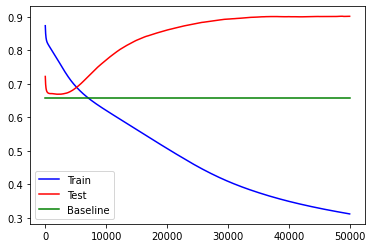

In [37]:
pt.plot(curves[0], 'b-')
pt.plot(curves[1], 'r-')
pt.plot([0, len(curves[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend(["Train","Test","Baseline"])
pt.show()

In [43]:
# play against AI

# The depth-limited minimax algorithm with NN as eval function
# Returns parent and child utilities
def minimax_eval(state, max_depth, player):
    if state.is_leaf():
        return state.score_for_max_player(), []
    elif max_depth == 0:
        x = encode(state).unsqueeze(0)
        u = net(x)
        return u, []
    else:
        child_utilities = [
            minimax(state.perform(action), max_depth - 1)[0]
            for action in state.valid_actions()]
        #if state.is_max_players_turn():
        if player == 1:
            return max(child_utilities), child_utilities
        else:
            return min(child_utilities), child_utilities

def play_it():
    state = initial_state(row_size=7, col_size=7,contig=4)
    turn = 0
    while not state.is_leaf():
        random_number = random.uniform(0,1)
        if random_number < 0.15:
          turn = (turn + 1)%2
        print(state)
        print('0123456')

        #if state.is_max_players_turn():
        if turn == 0:
            choice = input('Enter zero-based col: ')
            col = int(choice)
            #row,col = map(int, choice.split(","))
            row = state.get_next_open_row(col)
            state.board[row,col] = 1
            turn = (turn + 1)%2
            print(turn)
        else:
            print("AI's move:")
            utility, child_utilities = minimax_eval(state, max_depth=4, player = -1)
            ties = (np.array(child_utilities) == utility)
            tie_index = np.flatnonzero(ties)
            actions = state.valid_actions()
            action = actions[np.random.choice(tie_index)]
            state = state.perform(action)
            turn = (turn + 1)%2
            print(turn)
    print(state)
    result = state.score_for_max_player()
    print(f"Final score: {result}")

.......
.......
.......
.......
.......
.......
0123456
Enter zero-based col: 3
1
.......
.......
.......
.......
.......
...X...
0123456
AI's move:
0
.......
.......
.......
.......
...O...
...X...
0123456
AI's move:
0
.......
.......
.......
.......
...O...
..XX...
0123456
Enter zero-based col: 4
1
.......
.......
.......
.......
...O...
..XXX..
0123456
AI's move:
0
.......
.......
.......
.......
...O...
.OXXX..
0123456
Enter zero-based col: 5
1
.......
.......
.......
.......
...O...
.OXXXX.
Final score: 1.0


In [ ]:
play_it()

In [96]:
PLAYER = 1
AI = -1
PLAYER_DICE = 1
AI_DICE = -1
ROW_NUMBER = 6
COLUMN_NUMBER = 7
ARRAY_LENGTH = 4

def count_weight(array_4, player_dice):
    weight = 0
    array_4 = np.array2string(array_4)
    array_4 = array_4.replace('[','')
    array_4 = array_4.replace(']','')
    array_4 = array_4.replace(' ','')
    #print(player_dice, array_4)


    #win case: no need for count weight
    #if array_4.count(player_dice) == 4:
    if array_4.find(str(player_dice)*3) >= 0:
        weight = 5
    elif array_4.find(str(player_dice)*2) >= 0:
        weight = 10
    elif array_4.find(str(player_dice)) >= 0:
        weight = 20
    else:
        weight = 20
    #print(weight)    
    return weight

def check_score(board_, winner):
    #print(winner == PLAYER)
    #print(winner == AI)
    check_dice = 0
    score = 20
    board = board_.copy()
    #print(board)
    #check the loser dice
    if winner == PLAYER:
        check_dice = AI_DICE
        #print(check_dice)
    if winner == AI:
        check_dice = PLAYER_DICE
        #print(check_dice)
    #print(check_dice)
    
    #sliding window
    for i in range(ROW_NUMBER - ARRAY_LENGTH + 1):
        for j in range (COLUMN_NUMBER - ARRAY_LENGTH + 1):
            array_row = board[i,j:j+ARRAY_LENGTH] 
            array_col = board[i:i+ARRAY_LENGTH, j]
            matrix = board[i:i+ARRAY_LENGTH, j:j+ARRAY_LENGTH]
            array_diag = np.diag(matrix)
            array_oppo_diag = np.diag(np.fliplr(matrix))
            temp_score = max(count_weight(array_row, check_dice) , count_weight(array_col, check_dice) , count_weight(array_diag, check_dice) , count_weight(array_oppo_diag, check_dice) )
            #print(temp_score)
            if score > temp_score:
                score = temp_score

    #miss count row
    for i in range(ROW_NUMBER - ARRAY_LENGTH + 1 , ROW_NUMBER):
        for j in range(COLUMN_NUMBER - ARRAY_LENGTH + 1):
            array_row = board[i,j:j+ARRAY_LENGTH]
            temp_score = count_weight(array_row, check_dice)
            #print(temp_score)
            if score > temp_score:
                score = temp_score
    
    #miss count col
    for j in range(COLUMN_NUMBER - ARRAY_LENGTH + 1, COLUMN_NUMBER):
        for i in range(ROW_NUMBER - ARRAY_LENGTH +1):
            array_col = board[i:i+ARRAY_LENGTH, j]
            temp_score = count_weight(array_col, check_dice)
            #print(temp_score)
            if score > temp_score:
                score = temp_score
    #print(score)
    if winner == PLAYER:
        return -score
    else:
        return score

In [97]:
def minimax_eval_new(state, max_depth, player):
    node_count = 0
    if state.is_leaf():
        return state.score_for_max_player(), [], node_count
    elif max_depth == 0:
        x = encode(state).unsqueeze(0)
        u = net(x)
        return u, [], node_count
    else:
        child_utilities = [
            minimax(state.perform(action), max_depth - 1)[0]
            for action in state.valid_actions()]
        #if state.is_max_players_turn():
        if player == 1:
            return max(child_utilities), child_utilities, int(node_count + len(child_utilities))
        else:
            return min(child_utilities), child_utilities, int(node_count + len(child_utilities))



def test_hundred_times():
    SIMPLE_AI_winning_time = 0
    AI_winning_time = 0
    tie_game_time = 0
    visit_count_list = []
    score_count_list = []

    
    for i in range(100):
      state = initial_state(row_size=7, col_size=7,contig=4)
      turn = 0
      visit_node = 0
      while not state.is_leaf():
          random_number = random.uniform(0,1)
          if random_number < 0.15:
            turn = (turn + 1)%2
          #print(state)
          #print('0123456')

          #if state.is_max_players_turn():
          if turn == 0:
              #choice = input('Enter zero-based col: ')
              #col = int(choice)
              actions = state.valid_actions()
              numpy_list = actions.numpy()
              #print(numpy_list.size,numpy_list)
              if numpy_list.size > 0:
                col = np.random.choice(numpy_list[:,1], size=1)[0]
              else:
                tie_game_time += 1
                break
              row = state.get_next_open_row(col)
              state.board[row,col] = 1
              turn = (turn + 1)%2
              #print(turn)
          else:
              #print("AI's move:")
              utility, child_utilities, node_count = minimax_eval_new(state, max_depth=4, player = -1)
              #print(node_count*40)
              visit_node += node_count*40 + 1
              #print(child_utilities)
              ties = (np.array(child_utilities) == utility)
              tie_index = np.flatnonzero(ties)
              actions = state.valid_actions()
              if actions.size(dim = 0) == 0:
                tie_game_time += 1
                break
              action = actions[np.random.choice(tie_index)]
              state = state.perform(action)
              turn = (turn + 1)%2
              #print(turn)
      #print(state)
      result = state.score_for_max_player()
      if result == 1.0:
        SIMPLE_AI_winning_time += 1
      if result == -1.0:
        AI_winning_time += 1
      print(f"Final score: {result}")
      visit_count_list.append(visit_node)
      board = state.board[:state.board.size(dim=1)-1,:].numpy().astype(int)
      score_count_list.append(check_score(board, int(result)))
      #print(score_count_list)
      #print(board)
      #print(visit_node)
    
    return SIMPLE_AI_winning_time, AI_winning_time, tie_game_time, visit_count_list, score_count_list

In [ ]:
test_hundred_times()

Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: -1.0
Final score: 1.0
Final score: 1.0
Final score: -1.0
Final score: 1.0
F